# Example 6.2 Random Walk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class RandomWalk:
    def __init__(self):
        self.current_state = None

    def reset(self):
        # State starts at C
        ## States are [T1, A, B, C, D, E, T2]
        self.current_state = 3
        return {"state":self.current_state}

    def is_terminated(self):
        if self.current_state in [0, 6]:
            return True
        return False

    def step(self, action:int):
        # 0 means left and 1 means right
        if self.current_state is None:
            raise ValueError("Please reset the environment first")
        if self.is_terminated():
            return {"state": self.current_state, "action":action, "reward": 0.0}
        if action not in [0, 1]:
            raise ValueError("Invalid action taken")
        
        if action == 0:
            self.current_state -= 1
        else:
            self.current_state += 1

        reward = 0.0
        if self.current_state == 6:
            reward = +1.0

        return {"state":self.current_state, "action":action, "reward":reward}

In [3]:
def TD_evaluation(
    V_init:np.ndarray,
    V_star:np.ndarray,
    policy:np.ndarray,
    episodes:int=100,
    gamma:float=1.0,
    alpha:float=0.1, 
    runs:int=1
):
    random_walk = RandomWalk()
    history = [{'RMS':0, 'V':V_init.copy()} for _ in range(episodes)]

    for r in range(runs):
        V = V_init.copy()
        for episode in range(episodes):
            random_walk.reset()
    
            while not random_walk.is_terminated():
                # Take the current state
                current_state = random_walk.current_state
                # The action is taken according to the policy
                action = np.random.choice([0, 1], p=policy[random_walk.current_state])
                # Take the step to see what reward will be observed, and what is the new state
                feedback = random_walk.step(action)
                new_state, reward = feedback['state'], feedback['reward']
                # Update the value function: V(s) = V(s) + \alpha * (r + \gamma * V(s') - V(s))
                V[current_state] = V[current_state] + alpha * (reward + gamma * V[new_state] - V[current_state])

            RMS = np.sqrt(np.mean(np.square(V[1:-1] - V_star[1:-1])))
            history[episode]['RMS'] += 1 / (r + 1) * (RMS - history[episode]['RMS'])
            history[episode]['V'] += 1 / (r + 1) * (V - history[episode]['V'])

    history.insert(0, 
                   {'RMS':np.sqrt(np.mean(np.square(V_init[1:-1] - V_star[1:-1]))), 
                    'V':V_init.copy()})
    return V, history

In [4]:
V_init = np.array([0, 1/2, 1/2, 1/2, 1/2, 1/2, 0], dtype=np.float32)
V_star = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 0], dtype=np.float32)
policy = np.ones(shape=(7, 2), dtype=np.float32) * 0.5
histories = []
alphas = [0.01, 0.02, 0.03, 0.15, 0.04, 0.05, 0.1]

for alpha in alphas:
    V, history = TD_evaluation(V_init=V_init, V_star=V_star, policy=policy, episodes=100, gamma=1.0, alpha=alpha, runs=100)
    histories.append(history)

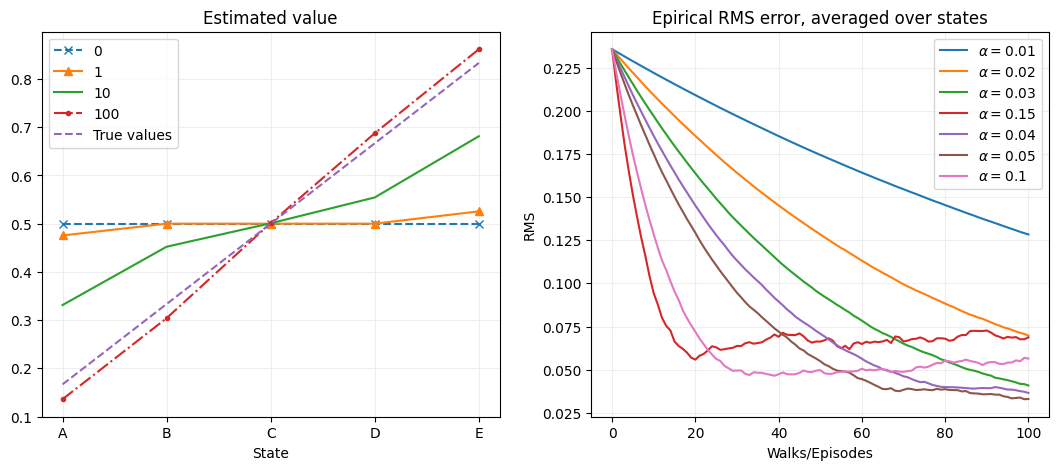

In [5]:
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(1, 2, 1)
markers = ['x--', '^-', '-', '.-.']

for i, walk in enumerate([0, 1, 10, 100]):
    ax.plot(range(5), histories[-1][walk]['V'][1:-1], markers[i], label=walk);
ax.plot(range(5), V_star[1:-1], '--', label='True values')
ax.grid(c='#eee')
ax.set_xticks(range(5))
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E'])
ax.set_title('Estimated value')
ax.set_xlabel('State')
ax.legend()

ax = plt.subplot(1, 2, 2)
for i, alpha in enumerate(alphas):
    ax.plot(range(len(histories[i])), np.array([x['RMS'] for x in histories[i]]), label=rf'$\alpha={alpha}$');

ax.set_title('Epirical RMS error, averaged over states')
ax.set_xlabel('Walks/Episodes')
ax.set_ylabel('RMS')
ax.grid(c='#eee')

ax.legend();